In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2
from Energy.Models.Model4_population import model4_population
from Energy.Models.Model4 import model4
from Energy.Models.Model3 import model3
from Energy.Models.Model5 import model5
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_sunhours import model4_sunhours
# import importlib
# importlib.reload(Energy.Models)
# Test

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


If needed: Fetch energy-data first

In [2]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

In [5]:
# df = get_energy_data(force_return=True)
df = get_energy_data()
df = prepare_data(df)

/Users/elias/Desktop/PTSFC/Energy/HelpFunctions/get_energy_data.py:17: UserWarning: The data is not up to date anymore. Please call fetch_energy_data
  warnings.warn("The data is not up to date anymore. Please call fetch_energy_data", UserWarning)


# Cross validate baseline model

Remove everything til last thursday night 12pm

In [7]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [8]:
from HelpFunctions.mix_models import mix_models_energy


def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)        
        
        pred = None     
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else:
            pred = mix_models_energy(model['function'][0], model['function'][1], df_before)
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

## Evaluation of selected Models

In [9]:
from Energy.Models import mstl
from Energy.Models import Model5
import importlib
importlib.reload(mstl)
importlib.reload(Model5)




models = [
    {
        'name': 'model5',
        'function': Model5.model5
    },
    {
        'name': 'model5_drop_2',
        'function': Model5.model5_drop_2
    },
    
    
    # {
    #     'name': 'baseline',
    #     'function': baseline
    #  },
    # {
    #     'name': 'mstl',
    #     'function': mstl.mstl
    #  },
    # {
    #     'name': 'mixed',
    #     'function': [[model4_sunhours, model4_holidays_2, model4_population],[1,1,1]]
    # },
    # {
    #     'name': 'MM mstl bl model5',
    #     'function': [[mstl.mstl, model5, baseline],[1,1,1]]
    # },
    # {
    #     'name': 'MM bl model5',
    #     'function': [[model5, baseline],[1,1]]
    # },
    # {
    #     'name': 'MM mstl model5',
    #     'function': [[mstl.mstl, model5],[1,1]]
    # },
]

In [10]:
evaluate_models(models, df_cval, last_x=30, weeks=True)
# Test

*********** Start the evaluation of Model model5 ***********
Iteration 0 of 30
Iteration 1 of 30


KeyboardInterrupt: 

### Save evaluations in pkl file

In [43]:
# with open('./Model evaluations/mm_m5_bl_m4_x.pkl', 'wb') as f:
#     pickle.dump(models, f)

# with open('./Model evaluations/m4_pop_m5.pkl', 'rb') as f:
#     models2 = pickle.load(f)

### Create a table that only contains the different scores of the different models

In [47]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)

### Plot the densities of the obtained scores

      model5: 36 hour  model5_drop_2: 36 hour
mean         7.631791                8.769858
std          3.695240                4.374655
      model5: 40 hour  model5_drop_2: 40 hour
mean         8.484731               11.668510
std          3.436270                4.924168
      model5: 44 hour  model5_drop_2: 44 hour
mean         6.189328                8.334472
std          3.179364                2.221755
      model5: 60 hour  model5_drop_2: 60 hour
mean         6.632302                7.085336
std          3.692273                3.166683
      model5: 64 hour  model5_drop_2: 64 hour
mean         7.504815                8.744257
std          4.200003                4.401936
      model5: 68 hour  model5_drop_2: 68 hour
mean         8.639550               11.581125
std          5.376772                4.670057


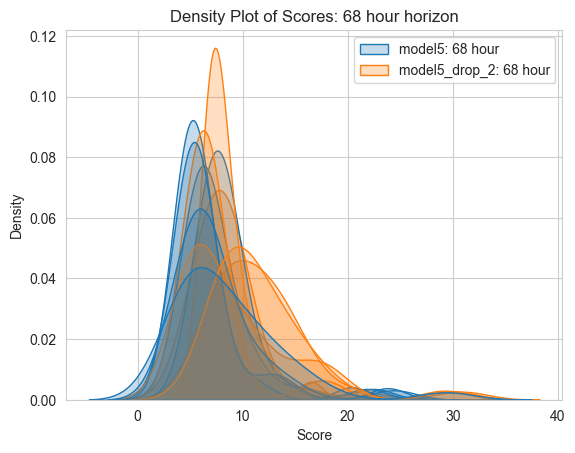

In [49]:
# models_display = ['MM mstl bl model5', 'MM bl model5','MM mstl model5']
models_display = [m['name'] for m in models]
# models_display = ['baseline', 'model4_sunhours', 'model4_holidays_2', 'model4', 'model4_population']
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    # sns.kdeplot(data=score_df.loc[:,[f'baseline: {h}',f'model3: {h}',f'MM_baseline_model3: {h}']], fill=True)
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    print(score_df.loc[:,[f'{m}: {h}' for m in models_display]].agg(['mean','std']))
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.savefig(f'plots/density_plot_{h.replace(" ", "_")}.png')
    # plt.show()

In [ ]:
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    # Plot values from two columns over time
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na['model1: 36 hour'], label='model1')
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na['model2: 36 hour'], label='model2')
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label='model4')
        # Adding labels and title
    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.savefig(f'plots/line_plot_{h.replace(" ", "_")}.png')
    
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

#### Plot Whole evaluation for a model

In [ ]:
[m['name'] for m in models]

In [ ]:


import matplotlib.pyplot as plt

def plot_evaluation(evaluation_data):
    # Assuming your DataFrame is named df
    numeric_columns = evaluation_data.select_dtypes(include='number')
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for column in numeric_columns.columns:
        plt.plot(evaluation_data.index, evaluation_data[column], label=column)
    
    # Adding labels and legend
    plt.xlabel('Forecast Date')
    plt.ylabel('Values')
    plt.title('Line Plot for Numeric Columns')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'plots/evaluation_overview.png')
    plt.show()

plot_evaluation(models[1]['evaluation'][models[1]['evaluation']['horizon'] == '36 hour'])

### Search for outliers (highest scores per horizon)

In [ ]:
models_display = ['model4_holidays_2']
horizons = [36]
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    for c in [f'{m}: {h}' for m in models_display]:
        df_sorted = score_df[c].sort_values().dropna().tail(10)
        
        
        print(f'{c}')
        print(df_sorted)

In [ ]:
[m['name'] for m in models]

In [ ]:
models[5]